In [66]:
fonts = [
    "Oswald", "Roboto", "Open Sans", "Ubuntu", "PT Serif",
    "Dancing Script", "Fredoka One", "Arimo", "Noto Sans", "Patua One"
]


**1. DATA GENERATION**

In [154]:
# Data Generation
import os
from PIL import Image, ImageDraw, ImageFont
import random

# Paths
fonts_dir = '/home/krishna/Documents/Niqo_Robotics/Font_Detection/fonts/'  # Directory containing .ttf font files
output_dir = '/home/krishna/Documents/Niqo_Robotics/Font_Detection/generated_images/'  # Directory to save generated images

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Image generation parameters
num_images = 1000
image_width, image_height = 128, 128

fonts = [
    "Arimo-Regular", "DancingScript-Regular", "FredokaOne-Regular", "NotoSans-Regular", "OpenSans-Regular",
    "Oswald", "PTSerif-Regular", "PatuaOne-Regular", "Roboto", "Ubuntu-Regular"
]

for i in range(num_images):
    # Create a white background image
    img = Image.new('RGB', (image_width, image_height), color='white')
    draw = ImageDraw.Draw(img)

    # Randomly decide how many instances of "Hello, World!" to add (1 to 2)
    num_instances = random.randint(1, 2)
    annotations = []

    for _ in range(num_instances):
        # Randomly select a font
        font_name = random.choice(fonts)
        font_path = os.path.join(fonts_dir, f"{font_name}.ttf")
        font_size = random.randint(12, 20)  # Adjusted font size
        font = ImageFont.truetype(font_path, font_size)

        # Text properties
        text = "Hello, World!"

        # Calculate text size using textbbox
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        # Random position
        max_x = image_width - text_width
        max_y = image_height - text_height
        if max_x <= 0 or max_y <= 0:
            continue  # Skip if text doesn't fit
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # Draw text
        draw.text((x, y), text, font=font, fill='black')

        # Save annotation (bounding box and font)
        bbox = [x, y, x + text_width, y + text_height]
        annotations.append({'bbox': bbox, 'font': font_name})

    if not annotations:
        continue  # Skip saving if no annotations

    # Save image
    image_path = os.path.join(output_dir, f"image_{i}.png")
    img.save(image_path)

    # Save annotations
    annotation_path = os.path.join(output_dir, f"image_{i}.txt")
    with open(annotation_path, 'w') as f:
        for ann in annotations:
            bbox = ann['bbox']
            font_name = ann['font']
            f.write(f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},{font_name}\n")


**DATA ANNOTATION**

In [155]:
import glob
import pandas as pd

# Get all annotation files
annotation_files = glob.glob(os.path.join(output_dir, '*.txt'))

data = []

for ann_file in annotation_files:
    image_name = os.path.basename(ann_file).replace('.txt', '.png')
    image_path = os.path.join(output_dir, image_name)
    with open(ann_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            x_min, y_min, x_max, y_max, font_name = line.strip().split(',')
            data.append([image_path, int(x_min), int(y_min), int(x_max), int(y_max), font_name])

# Create a DataFrame
df = pd.DataFrame(data, columns=['image_path', 'x_min', 'y_min', 'x_max', 'y_max', 'font_label'])

# Save to CSV
df.to_csv('/home/krishna/Documents/Niqo_Robotics/Font_Detection/annotations.csv', index=False)


**Model Architecture Design**

In [156]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np

In [157]:
class HelloWorldDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform

        # Encode font labels
        self.fonts = [
            "Arimo-Regular", "DancingScript-Regular", "FredokaOne-Regular", "NotoSans-Regular", "OpenSans-Regular",
            "Oswald", "PTSerif-Regular", "PatuaOne-Regular", "Roboto", "Ubuntu-Regular"
        ]
        self.font_to_idx = {font: idx for idx, font in enumerate(self.fonts)}

        # Group annotations by image
        self.image_annotations = self.annotations.groupby('image_path')

        # Get list of image paths
        self.image_paths = self.annotations['image_path'].unique()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        records = self.image_annotations.get_group(image_path)

        boxes = []
        labels = []

        for _, record in records.iterrows():
            bbox = [record['x_min'], record['y_min'], record['x_max'], record['y_max']]
            boxes.append(bbox)
            labels.append(self.font_to_idx[record['font_label']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return image, target


In [158]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])


In [111]:
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.features(x)


In [159]:
class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors_per_location):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 256, kernel_size=3, padding=1)
        self.objectness = nn.Conv2d(256, num_anchors_per_location, kernel_size=1)
        self.regressor = nn.Conv2d(256, num_anchors_per_location * 4, kernel_size=1)

    def forward(self, x):
        x = nn.ReLU()(self.conv(x))
        objectness = torch.sigmoid(self.objectness(x))  
        bbox_deltas = self.regressor(x)  
        return objectness, bbox_deltas

class FontClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FontClassifier, self).__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.conv(x)
        x = x.mean([2, 3])  # Global average pooling
        return x

class HelloWorldDetector(nn.Module):
    def __init__(self, num_classes, num_anchors_per_location):
        super(HelloWorldDetector, self).__init__()
        self.backbone = CNNBackbone()
        self.rpn = RPN(in_channels=32, num_anchors_per_location=num_anchors_per_location)
        self.font_classifier = FontClassifier(in_channels=32, num_classes=num_classes)

    def forward(self, images):
        features = self.backbone(images)
        objectness, bbox_deltas = self.rpn(features)
        font_scores = self.font_classifier(features)
        return objectness, bbox_deltas, font_scores


**TRAINING THE MODEL**

In [115]:
def generate_anchors(feature_map_size, scales, ratios):
    anchors = []
    grid_height, grid_width = feature_map_size
    for y in range(grid_height):
        for x in range(grid_width):
            center_x = x + 0.5
            center_y = y + 0.5
            for scale in scales:
                for ratio in ratios:
                    w = scale * np.sqrt(ratio)
                    h = scale / np.sqrt(ratio)
                    anchors.append([
                        center_x - w / 2,
                        center_y - h / 2,
                        center_x + w / 2,
                        center_y + h / 2
                    ])
    return torch.tensor(anchors, dtype=torch.float32)


In [116]:
def compute_iou(anchors, gt_boxes):
    num_anchors = anchors.size(0)
    num_gt_boxes = gt_boxes.size(0)
    ious = torch.zeros(num_anchors, num_gt_boxes)
    for i in range(num_anchors):
        anchor = anchors[i]
        anchor_area = (anchor[2] - anchor[0]) * (anchor[3] - anchor[1])
        for j in range(num_gt_boxes):
            gt = gt_boxes[j]
            inter_x1 = max(anchor[0], gt[0])
            inter_y1 = max(anchor[1], gt[1])
            inter_x2 = min(anchor[2], gt[2])
            inter_y2 = min(anchor[3], gt[3])
            if inter_x1 < inter_x2 and inter_y1 < inter_y2:
                inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
                gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
                union_area = anchor_area + gt_area - inter_area
                ious[i, j] = inter_area / union_area
    return ious


In [117]:
def assign_labels(anchors, gt_boxes, gt_labels, iou_threshold=0.5):
    ious = compute_iou(anchors, gt_boxes)
    max_iou, max_iou_idx = ious.max(dim=1)
    labels = torch.full((anchors.size(0),), -1, dtype=torch.int64)  # -1 means ignore
    # Positive anchors
    positive_indices = max_iou >= iou_threshold
    labels[positive_indices] = gt_labels[max_iou_idx[positive_indices]]
    # Negative anchors
    negative_indices = max_iou < 0.1
    labels[negative_indices] = 0  # Background class
    # Bounding box regression targets
    bbox_targets = torch.zeros_like(anchors)#, dtype=gt_boxes.dtype)
    bbox_targets[positive_indices] = gt_boxes[max_iou_idx[positive_indices]]
    return labels, bbox_targets


In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time


In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [162]:
# Training Loop

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize dataset and dataloader
dataset = HelloWorldDataset('/home/krishna/Documents/Niqo_Robotics/Font_Detection/annotations.csv', transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=4,  # Increase batch size if possible
    shuffle=True,
    num_workers=4,  # Adjust based on your system
    collate_fn=lambda x: tuple(zip(*x))
)

# Initialize model
scales = [32, 64, 128]  
ratios = [0.5, 1.0, 2.0]
num_anchors_per_location = len(scales) * len(ratios)
num_classes = len(dataset.fonts)
model = HelloWorldDetector(num_classes=num_classes, num_anchors_per_location=num_anchors_per_location)
model = model.to(device)

# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for batch_idx, (images, targets) in enumerate(dataloader):
        images = torch.stack(images).to(device)
        batch_size = images.size(0)

        optimizer.zero_grad()
        objectness, bbox_deltas, font_scores = model(images)

        # Generate anchors
        _, _, feature_height, feature_width = objectness.shape
        anchors = generate_anchors((feature_height, feature_width), scales=scales, ratios=ratios)
        anchors = anchors.to(device)

        total_obj_loss = 0
        total_bbox_loss = 0
        total_class_loss = 0

        for i in range(batch_size):
            gt_boxes = targets[i]['boxes'].to(device)
            gt_labels = targets[i]['labels'].to(device)

            # Reshape objectness and bbox_deltas
            obj_pred = objectness[i].permute(1, 2, 0).reshape(-1)
            bbox_pred = bbox_deltas[i].permute(1, 2, 0).reshape(-1, 4)

            # Assign labels and targets
            labels, bbox_targets = assign_labels(anchors, gt_boxes, gt_labels)
            labels = labels.to(device)
            bbox_targets = bbox_targets.to(device)

            # Objectness loss
            obj_target = (labels >= 0).float()
            obj_loss = F.binary_cross_entropy(obj_pred, obj_target)

            # Bounding box regression loss
            positive_indices = labels >= 0
            if positive_indices.sum() > 0:
                bbox_loss = F.smooth_l1_loss(bbox_pred[positive_indices], bbox_targets[positive_indices])
            else:
                bbox_loss = torch.tensor(0.0).to(device)

            # Font classification loss
            font_score = font_scores[i].unsqueeze(0)  # [1, num_classes]
            class_loss = F.cross_entropy(font_score, gt_labels[0].unsqueeze(0))

            total_obj_loss += obj_loss
            total_bbox_loss += bbox_loss
            total_class_loss += class_loss

        total_loss = total_obj_loss + total_bbox_loss + total_class_loss
        total_loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], "
                  f"Loss: {total_loss.item():.4f}, Obj Loss: {total_obj_loss.item():.4f}, "
                  f"BBox Loss: {total_bbox_loss.item():.4f}, Class Loss: {total_class_loss.item():.4f}")

    epoch_end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_end_time - epoch_start_time:.2f}s")


Using device: cpu
Epoch [1/10], Batch [1/250], Loss: 12.0229, Obj Loss: 2.8194, BBox Loss: 0.0049, Class Loss: 9.1986
Epoch [1/10], Batch [11/250], Loss: 11.4442, Obj Loss: 1.7274, BBox Loss: 0.0046, Class Loss: 9.7121
Epoch [1/10], Batch [21/250], Loss: 11.1139, Obj Loss: 1.4243, BBox Loss: 0.0029, Class Loss: 9.6867
Epoch [1/10], Batch [31/250], Loss: 10.4749, Obj Loss: 1.2795, BBox Loss: 0.0017, Class Loss: 9.1938
Epoch [1/10], Batch [41/250], Loss: 10.0720, Obj Loss: 1.0966, BBox Loss: 0.0010, Class Loss: 8.9744
Epoch [1/10], Batch [51/250], Loss: 11.3329, Obj Loss: 1.5960, BBox Loss: 0.0006, Class Loss: 9.7363
Epoch [1/10], Batch [61/250], Loss: 10.9681, Obj Loss: 2.1354, BBox Loss: 0.0004, Class Loss: 8.8323
Epoch [1/10], Batch [71/250], Loss: 9.9623, Obj Loss: 0.7382, BBox Loss: 0.0002, Class Loss: 9.2240
Epoch [1/10], Batch [81/250], Loss: 10.4862, Obj Loss: 0.8658, BBox Loss: 0.0003, Class Loss: 9.6201
Epoch [1/10], Batch [91/250], Loss: 10.2564, Obj Loss: 1.1903, BBox Loss: 0

**INFERENCE**

In [167]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Ensure model is in evaluation mode
model.eval()

# Load and preprocess the test image
test_image = Image.open('/home/krishna/Documents/Niqo_Robotics/Font_Detection/image_2.png').convert('RGB')
input_image = transform(test_image).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    objectness, bbox_deltas, font_scores = model(input_image)

print("Original shapes:")
print("objectness shape:", objectness.shape)
print("bbox_deltas shape:", bbox_deltas.shape)
print("font_scores shape:", font_scores.shape)

# Extract dimensions
batch_size = objectness.shape[0]
num_anchors_per_location = objectness.shape[1]  # Should be 1 if only one anchor per location
feature_height, feature_width = objectness.shape[2], objectness.shape[3]
num_classes = font_scores.shape[1]

total_anchors = batch_size * num_anchors_per_location * feature_height * feature_width

print(f"Feature map size: {feature_height} x {feature_width}")
print(f"Number of anchors per location: {num_anchors_per_location}")
print(f"Total anchors: {total_anchors}")

# Reshape objectness
objectness = objectness.permute(0, 2, 3, 1).reshape(-1)
objectness = objectness.cpu().numpy()

# Reshape bbox_deltas
bbox_deltas = bbox_deltas.view(batch_size, num_anchors_per_location, 4, feature_height, feature_width)
bbox_deltas = bbox_deltas.permute(0, 3, 4, 1, 2).reshape(-1, 4)
bbox_deltas = bbox_deltas.cpu().numpy()

# Process font_probs
font_probs = nn.Softmax(dim=1)(font_scores)  # Shape: [batch_size, num_classes]
font_probs = font_probs.unsqueeze(1).repeat(1, feature_height * feature_width * num_anchors_per_location, 1)
font_probs = font_probs.view(-1, num_classes)
font_probs = font_probs.cpu().numpy()

print("After reshaping:")
print(f"objectness shape: {objectness.shape}")
print(f"bbox_deltas shape: {bbox_deltas.shape}")
print(f"font_probs shape: {font_probs.shape}")
print(f"indices shape: {indices.shape}")

# Threshold objectness scores
threshold = 0.5
indices = objectness > threshold  # Shape: [batch_size * total_anchors]

# Get bounding boxes and font predictions
pred_boxes = bbox_deltas[indices]
pred_fonts = font_probs.argmax(axis=1)[indices]
pred_confidences = font_probs.max(axis=1)[indices]

print("Number of detections:", len(pred_boxes))
print("Predicted fonts:", pred_fonts)
print("Predicted confidences:", pred_confidences)


Original shapes:
objectness shape: torch.Size([1, 9, 32, 32])
bbox_deltas shape: torch.Size([1, 36, 32, 32])
font_scores shape: torch.Size([1, 10])
Feature map size: 32 x 32
Number of anchors per location: 9
Total anchors: 9216
After reshaping:
objectness shape: (9216,)
bbox_deltas shape: (9216, 4)
font_probs shape: (9216, 10)
indices shape: (9216,)
Number of detections: 9216
Predicted fonts: [4 4 4 ... 4 4 4]
Predicted confidences: [0.17877178 0.17877178 0.17877178 ... 0.17877178 0.17877178 0.17877178]


**VISUALIZATION**

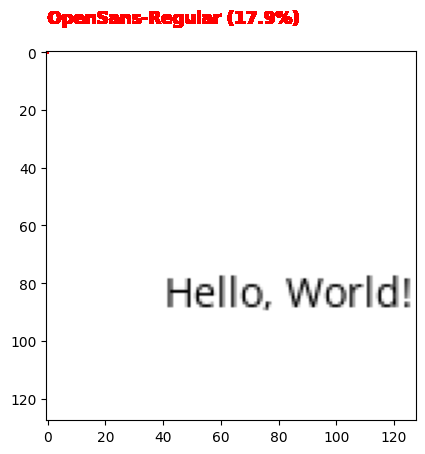

In [168]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.imshow(test_image)

for bbox, font_idx, confidence in zip(pred_boxes, pred_fonts, pred_confidences):
    x_min, y_min, x_max, y_max = bbox
    width, height = x_max - x_min, y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add font label and confidence
    font_name = fonts[font_idx]
    ax.text(x_min, y_min - 10, f"{font_name} ({confidence*100:.1f}%)", color='red', fontsize=12, weight='bold')

plt.show()
